# Example: Variational Auto-Encoder

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [2]:
pokemon = datasets.ImageFolder("../datasets/img_align_celeba")
transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
pokemon.transform = transformer

train, test, val = torch.utils.data.random_split(pokemon, (0.8, 0.1, 0.1))

len(train), len(test), len(val)

(35058, 4382, 4382)

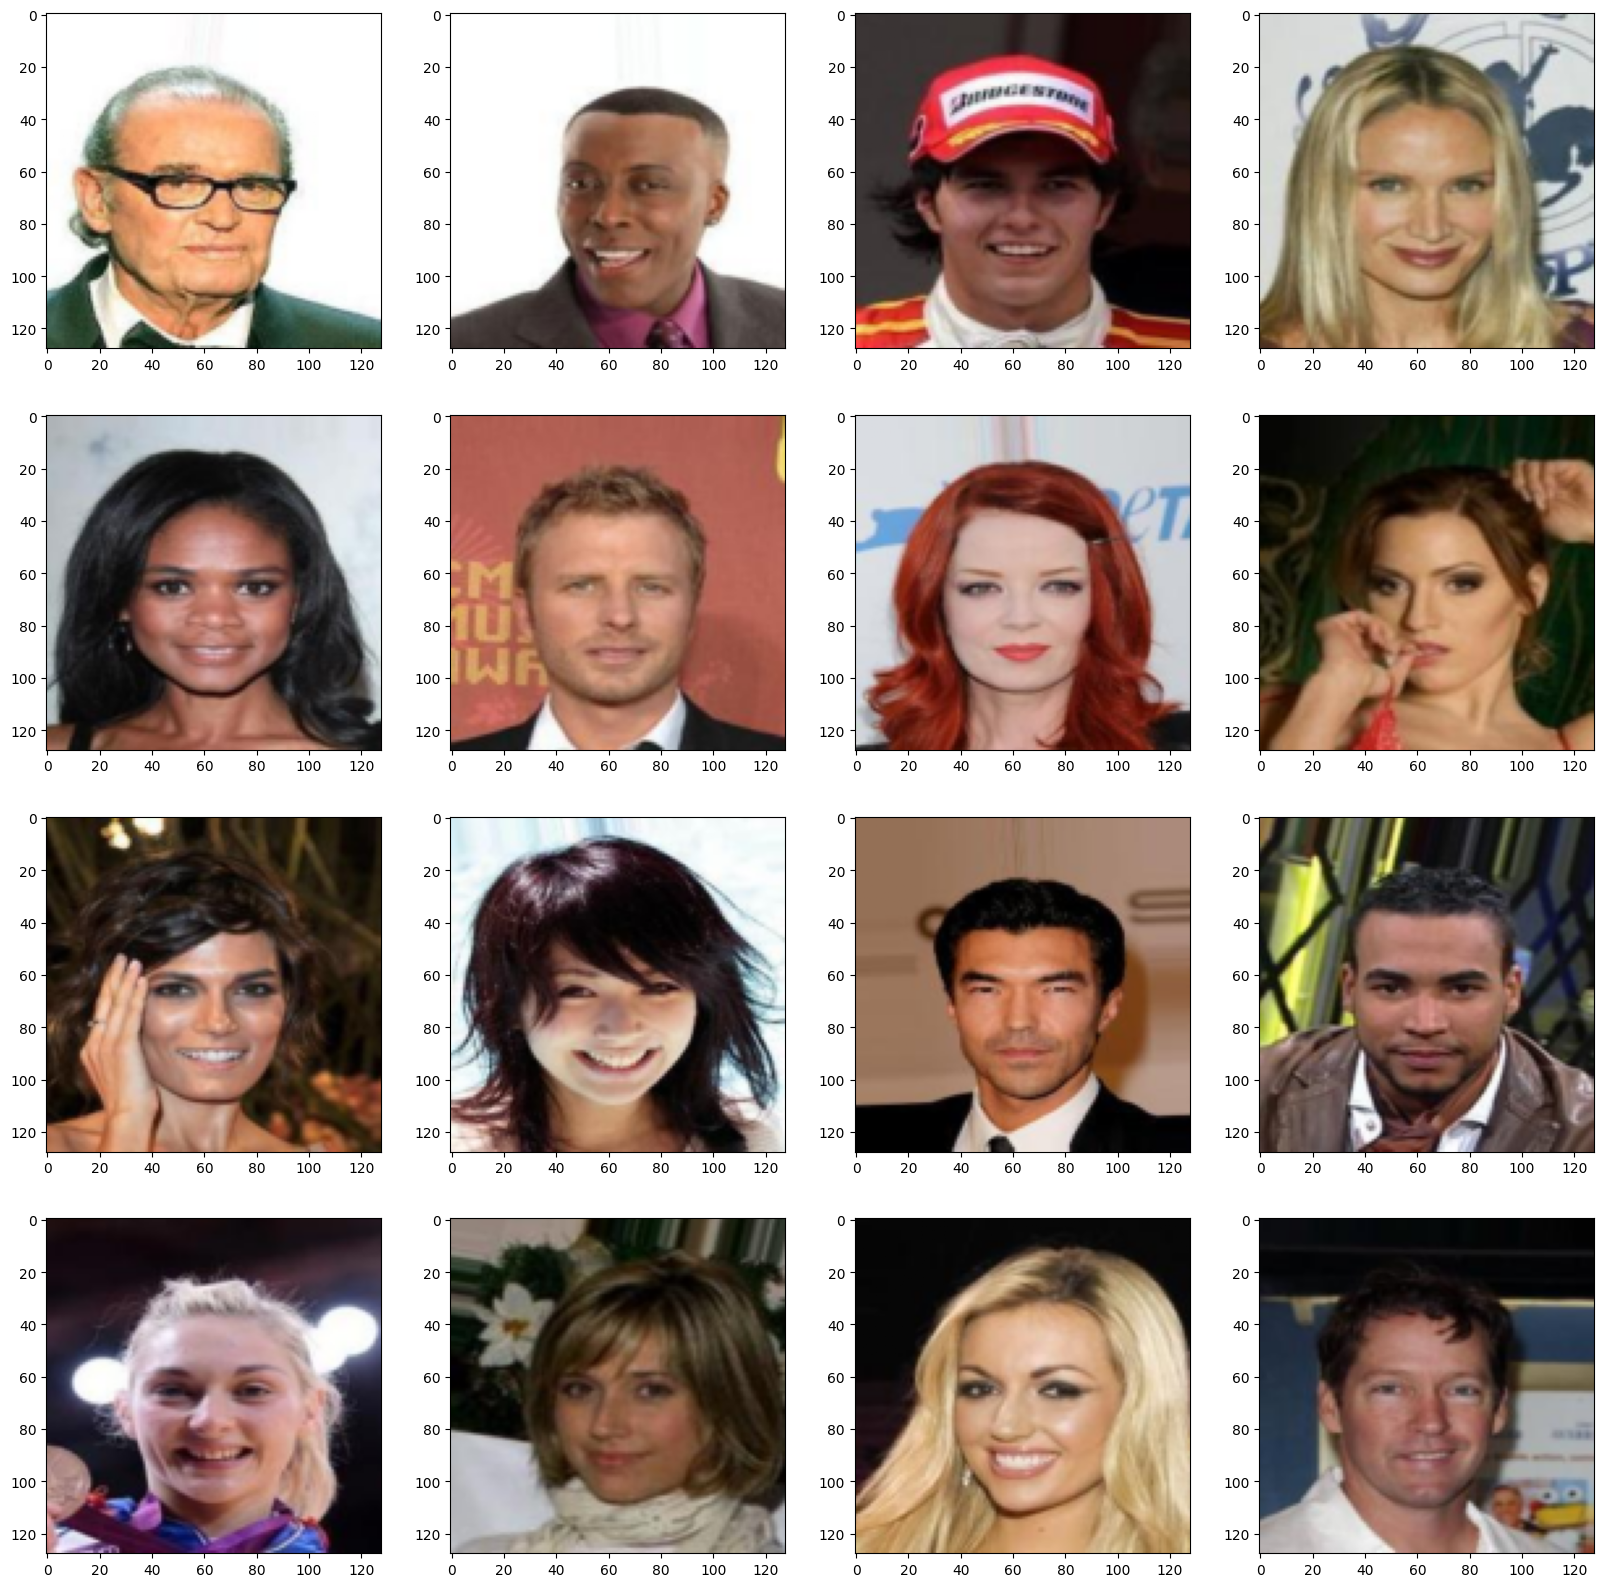

In [3]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

data_iter = torch.utils.data.DataLoader(pokemon, batch_size=32, shuffle=True)
for X, y in data_iter:
    img = X[:20, :, :, :].permute(0, 2, 3, 1)
    for i, ax in enumerate(axes):
        ax.imshow(img[i])
    break

## Variational Auto-Encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 128 -> 64
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 64 -> 32
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 16
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(1024, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 64 -> 128
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
enc = Encoder(2)
dec = Decoder(2)
x = torch.randn(16, 3, 128, 128)
enc(x).shape, dec(enc(x)).shape

(torch.Size([16, 2, 1, 1]), torch.Size([16, 3, 128, 128]))

In [5]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder(2*z_size)
        self.dec = Decoder(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 3, 128, 128)
g = VAE(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

## Training procedure

In [72]:
EPOCHS = 20
Z_SIZE = 500
BATCH_SIZE = 256
lambda_rec_error = 10000

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

generator = VAE(z_size=Z_SIZE).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

In [73]:
for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda')
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # loss is reconstruction error + kl regularization term
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))
    
    batch_history = []
    with torch.no_grad():
        for i, (images, _) in enumerate(val_loader):
            images = images.to('cuda')
            preds, _, mu, log_var = generator(images)
            kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
            rec_error = lambda_rec_error * criterion(preds, images)
            loss = rec_error + kl_reg
            batch_history.append(loss.item())
        val_history.append(torch.mean(torch.tensor(batch_history)))
        
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    test_loss = 0
    for i, (images, _) in enumerate(test_loader):
        images = images.to('cuda')
        preds, _, mu, log_var = generator(images)
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        test_loss += (rec_error + kl_reg).item()
    print(f"test loss = {test_loss / len(test_loader)}")

epoch 0, train_loss 6295.28466796875, val_loss 5769.1259765625
epoch 1, train_loss 5694.720703125, val_loss 5605.34912109375
epoch 2, train_loss 5579.04833984375, val_loss 5540.48974609375
epoch 3, train_loss 5519.68994140625, val_loss 5504.8857421875
epoch 4, train_loss 5483.3935546875, val_loss 5464.0048828125
epoch 5, train_loss 5456.8818359375, val_loss 5458.9287109375
epoch 6, train_loss 5437.04541015625, val_loss 5443.724609375
epoch 7, train_loss 5418.93603515625, val_loss 5450.7275390625
epoch 8, train_loss 5402.55908203125, val_loss 5429.95068359375
epoch 9, train_loss 5387.57470703125, val_loss 5418.0048828125
epoch 10, train_loss 5371.671875, val_loss 5423.88525390625
epoch 11, train_loss 5356.17236328125, val_loss 5433.072265625
epoch 12, train_loss 5342.1845703125, val_loss 5419.62890625
epoch 13, train_loss 5326.0361328125, val_loss 5428.029296875
epoch 14, train_loss 5312.62255859375, val_loss 5430.0400390625
epoch 15, train_loss 5299.74267578125, val_loss 5422.102050781

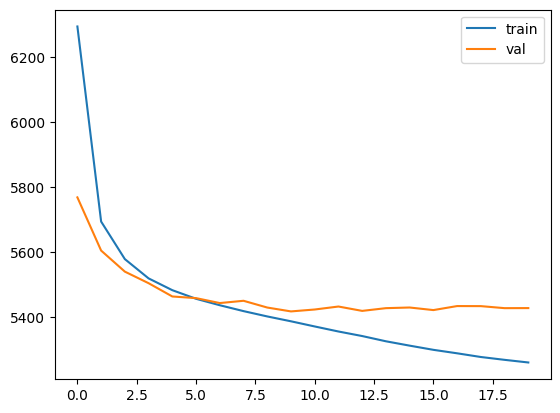

In [74]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()

## encoding decoding specific pokemon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


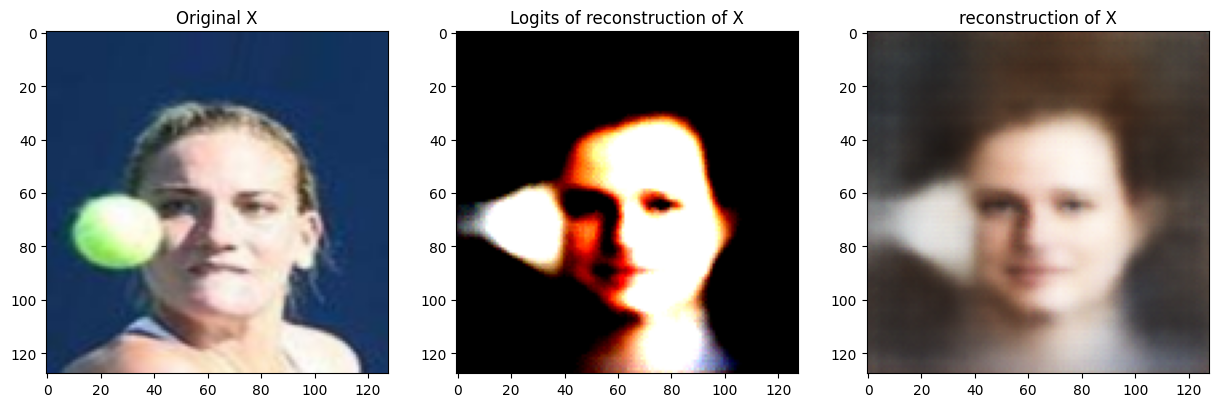

In [96]:
from itertools import islice

data_iter = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

idx = 102
X_sample, _ = next(islice(data_iter, idx, idx+1))
X_sample = X_sample[:1].to('cuda')

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(X_sample.cpu().squeeze().permute(1, 2, 0), cmap='gray')
ax1.set_title("Original X")

ax2.imshow(y_pred.cpu().squeeze().detach().permute(1, 2, 0), cmap='gray')
ax2.set_title("Logits of reconstruction of X")

ax3.imshow(F.sigmoid(y_pred).cpu().squeeze().detach().permute(1, 2, 0), cmap='gray')
ax3.set_title("reconstruction of X")

plt.show()

## Sampling on the $z$-dimension manifold

In [30]:
d = 128
h, w = 30, 30
z1_range = torch.linspace(-10000, 10000, h)
z2_range = torch.linspace(-10000, 10000, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = (y_preds                      # (h*w, 3, d, d)
           .permute(1, 0, 2, 3)         # (3, h*w, d, d)
           .reshape(3, h, w, d, d)      # (3, h, w, d, d)
           .permute(0, 1, 3, 2, 4)      # (3, h, d, w, d)
           .reshape(3, h*d, w*d)        # (3, h*d, w*d)
           .permute(1, 2, 0))           # (h*d, w*d, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds)
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.show()

plt.savefig("../images/manifolds/celeba_manifold.svg", dpi=300)

OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB. GPU 0 has a total capacity of 12.00 GiB of which 0 bytes is free. Of the allocated memory 18.20 GiB is allocated by PyTorch, and 292.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Sampling manifold at random when $z > 2$

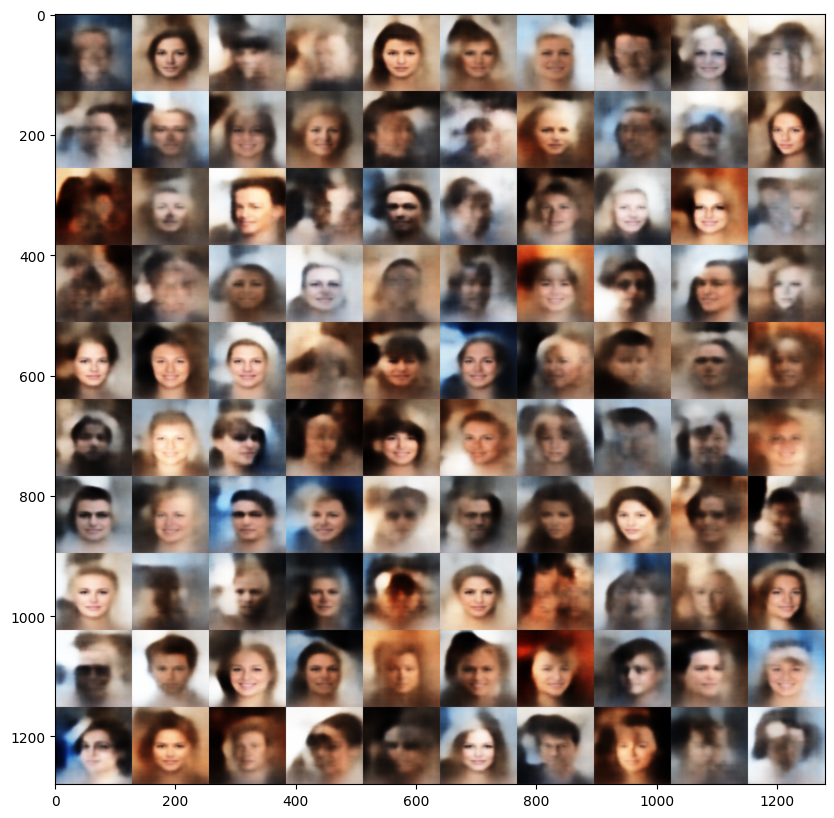

In [81]:
d = 128
h, w = 10, 10
z_vecs = torch.randn(h*w, Z_SIZE, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(z_vecs)).squeeze().cpu().detach()
y_preds = (y_preds                      # (h*w, 3, d, d)
           .permute(1, 0, 2, 3)         # (3, h*w, d, d)
           .reshape(3, h, w, d, d)      # (3, h, w, d, d)
           .permute(0, 1, 3, 2, 4)      # (3, h, d, w, d)
           .reshape(3, h*d, w*d)        # (3, h*d, w*d)
           .permute(1, 2, 0))           # (h*d, w*d, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

# plt.savefig("../images/manifolds/celebs0.svg", dpi=300)
plt.show()

## Interpolating 2 axes on manifold  

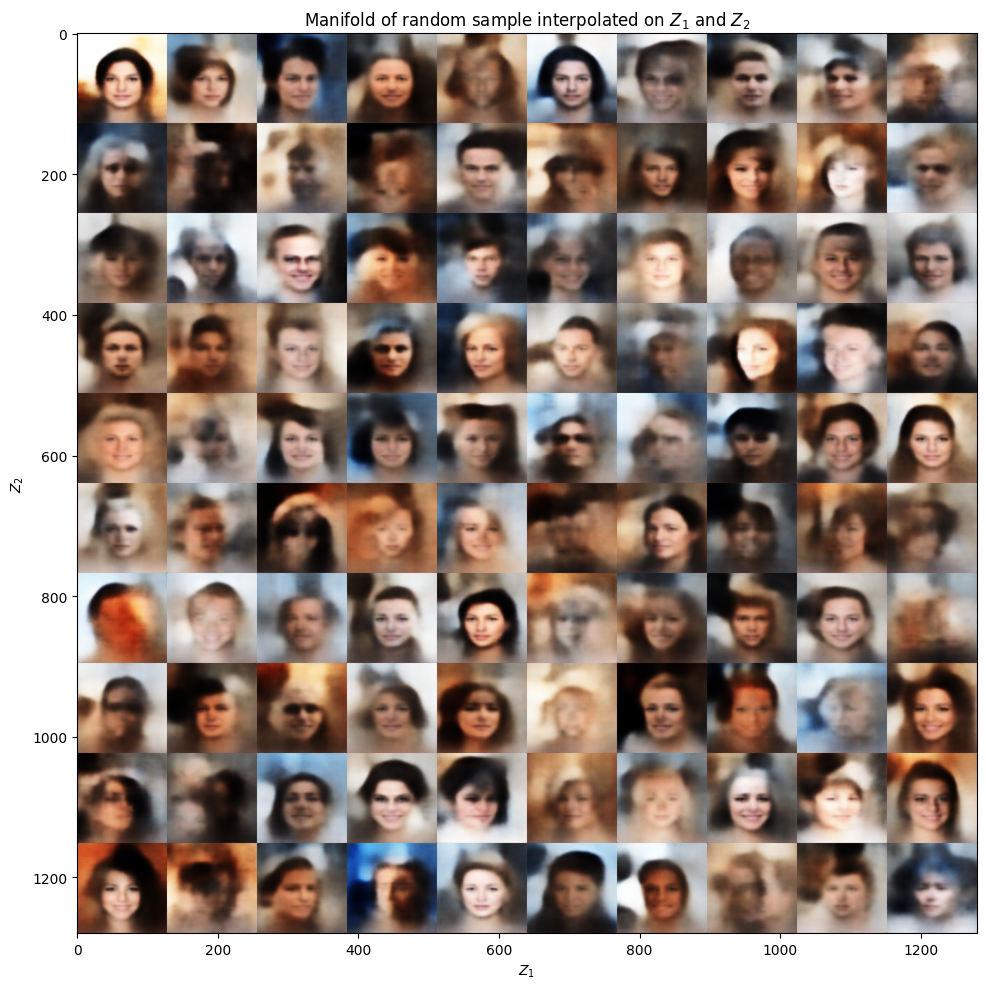

In [97]:
z1_range = torch.linspace(-10, 10, h)
z2_range = torch.linspace(-10, 10, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')
zz = torch.cat([zz, torch.randn(h*w, Z_SIZE-2, 1, 1, device='cuda')], dim=1)


y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()

y_preds = (y_preds                      # (h*w, 3, d, d)
           .permute(1, 0, 2, 3)         # (3, h*w, d, d)
           .reshape(3, h, w, d, d)      # (3, h, w, d, d)
           .permute(0, 1, 3, 2, 4)      # (3, h, d, w, d)
           .reshape(3, h*d, w*d)        # (3, h*d, w*d)
           .permute(1, 2, 0))           # (h*d, w*d, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds)
plt.axis('image')
plt.title(r'Manifold of random sample interpolated on $Z_1$ and $Z_2$')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.tight_layout()
# plt.savefig("../images/manifolds/celebs1.svg", dpi=300)
plt.show()